### If you are Wanting to test it out for yourself, please run every code box until you reach the hyperparamter tuning boxes
- From there, you will want to run the training code boxes and then find the testing code boxes after the training is complete
- For testing, you Should see something like this:
  - RNN_with_LSTM_model Testing
  - test_prompt = 'rick: kill summer <COMMA> morty <EXCLAMATIONMARK>'
  - print(RNN_with_LSTM_model.test(test_prompt, 1000))
- Change the test_prompt string to your desired prompt and the integer to however many characters you want the model to generate
  - Unlike when the models utilized word preprocessing, these models will accept any text as a valid prompt and there is no need to translate punctuation

### Needed to Run Properly (and all in the same directory)
1. AllScripts.txt
2. Folder named 'character_dataset'
3. Any imports that you do not already have installed

In [1]:
# Imports
import argparse
from collections import Counter
import itertools
import math
import matplotlib.pyplot as plt
from nltk.tokenize import regexp_tokenize
import numpy as np
import os
import pandas as pd
import pickle
import re
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

C:\Users\BluerayDestroyer6969\AppData\Local\Temp\ipykernel_36976\1967635484.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def custom_tokenizer(text):
    return list(text)

def clean_text(text):
    tokens = custom_tokenizer(text)
    return tokens

def load_words(file_path):
    input_file = os.path.join(file_path)
    with open(input_file, "r", encoding="utf-8") as f:
        data = f.read()

    return clean_text(data)

words = load_words('./AllScripts.txt')
unique_chars = sorted(set(words))
unique_chars.append('<UNK>')
unique_chars.append('<PAD>')

index_to_char = {index: char for index, char in enumerate(unique_chars)}
char_to_index = {char: index for index, char in enumerate(unique_chars)}
chars_index = [char_to_index[char] for char in words]

folder = './character_dataset'
with open(folder + '/clean_data.pickle', 'wb') as file:
    pickle.dump(words, file, protocol=pickle.HIGHEST_PROTOCOL)

with open(folder + '/index_to_char.pickle', 'wb') as file:
    pickle.dump(index_to_char, file, protocol=pickle.HIGHEST_PROTOCOL)

with open(folder + '/char_to_index.pickle', 'wb') as file:
    pickle.dump(char_to_index, file, protocol=pickle.HIGHEST_PROTOCOL)

with open(folder + '/chars_index.pickle', 'wb') as file:
    pickle.dump(chars_index, file, protocol=pickle.HIGHEST_PROTOCOL)

with open(folder + '/unique_chars.pickle', 'wb') as file:
    pickle.dump(unique_chars, file, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
class Dataset_Loader():
    data = None
    dataset_source_folder_path = None
    dataset_source_name = None

    def __init__(self, dSrcPath=None, dName=None):
        self.dataset_source_folder_path = dSrcPath
        self.dataset_source_name = dName

    def load(self):
        print('loading data...')

        index_to_char = None
        char_to_index = None

        # Training Dataset
        with open(self.dataset_source_folder_path + self.dataset_source_name + 'clean_data.pickle', 'rb') as file:
            dataset = pickle.load(file)

        with open(self.dataset_source_folder_path + self.dataset_source_name + 'index_to_char.pickle', 'rb') as file:
            index_to_char = pickle.load(file)

        with open(self.dataset_source_folder_path + self.dataset_source_name + 'char_to_index.pickle', 'rb') as file:
            char_to_index = pickle.load(file)

        with open(self.dataset_source_folder_path + self.dataset_source_name + 'chars_index.pickle', 'rb') as file:
            chars_index = pickle.load(file)

        with open(self.dataset_source_folder_path + self.dataset_source_name + 'unique_chars.pickle', 'rb') as file:
            unique = pickle.load(file)

        self.data = {
            'train': dataset,
            'index_to_char': index_to_char,
            'char_to_index': char_to_index,
            'chars_index': chars_index,
            'unique': unique
        }

In [4]:
class GenerationDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        char_window,
        data
    ):
        self.char_window = char_window
        self.index_to_char = data['index_to_char']
        self.char_to_index = data['char_to_index']
        self.chars_index = data['chars_index']

    def __len__(self):
        return len(self.chars_index) - self.char_window

    def __getitem__(self, idx):
        return (
            torch.tensor(self.chars_index[idx:idx+self.char_window]),
            torch.tensor(self.chars_index[idx+1:idx+self.char_window+1]),
        )

In [5]:
class Method_RNN_Generation(nn.Module):
    data = None
    dataset = None
    train_data = None
    
    max_epoch = 10
    learning_rate = 1e-3
    size = 1024
    num_layers = 2
    batch_size = 512
    char_window = 14
    dropout = 0.1

    def __init__(self, data):
        super(Method_RNN_Generation, self).__init__()
        self.data = data
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.initialize_layers()
        print(f'Total number of parameters: {self.count_parameters()}')

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def initialize_layers(self):
        num_chars = len(self.data['unique'])
        self.embedding = nn.Embedding(num_embeddings=num_chars, embedding_dim=self.size)
        self.rnn = nn.RNN(
            input_size=self.size,
            hidden_size=self.size,
            num_layers=self.num_layers,
            dropout=self.dropout,
            batch_first=True,
        )
        self.fc = nn.Linear(self.size, num_chars)
        self.dropout_layer = nn.Dropout(self.dropout)
        self.to(self.device)

    def initial_state(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.size).to(self.device)

    def forward(self, x, previous):
        embed = self.embedding(x)
        embed = self.dropout_layer(embed)
        out, current = self.rnn(embed, previous)
        out = self.fc(out)
        return out, current

    def train(self):
        print('--start training...')
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        loss_function = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        training_accuracies = []
        training_loss = []
        training_perplexity = []

        for epoch in range(self.max_epoch):
            total_loss = 0.0
            total_chars = 0

            for batch, (inputs, labels) in enumerate(self.train_data):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()

                batch_size = inputs.size(0)
                h0 = self.initial_state(batch_size)

                y_pred, h0 = self.forward(inputs, h0)
                loss = loss_function(y_pred.transpose(1, 2), labels)

                total_loss += loss.item() * batch_size
                total_chars += labels.numel()

                h0 = h0.detach()

                loss.backward()
                nn.utils.clip_grad_norm_(self.parameters(), max_norm=5)
                optimizer.step()

                if batch == 0:
                    _, predicted = torch.max(y_pred.data, 2)
                    total = labels.size(0) * labels.size(1)
                    correct = (predicted == labels).sum().item()
                    accuracy = correct / total

                    epoch_loss = total_loss / total_chars
                    perplexity = math.exp(epoch_loss)

                    print(f'[{epoch}, {batch}] loss: {loss.item()} accuracy: {accuracy} perplexity: {perplexity}')
                    training_accuracies.append(accuracy)
                    training_loss.append(loss.item())
                    training_perplexity.append(perplexity)
                    
            scheduler.step()

        return training_accuracies, training_loss, training_perplexity

    def test(self, text, next_chars=12):
        print('--start testing...')
        chars = list(text)
        fixed_chars = [char if char in char_to_index else '<UNK>' for char in chars]
        print(fixed_chars)
        h0 = self.initial_state(1)

        for _ in range(next_chars):
            x = torch.tensor([[self.dataset.char_to_index[char] for char in fixed_chars]]).to(self.device)
            y_pred, h0 = self.forward(x, h0)

            last_char_outputs = y_pred[0][-1]
            p = torch.nn.functional.softmax(last_char_outputs.cpu(), dim=0).detach().numpy()
            char_index = np.random.choice(len(last_char_outputs), p=p)
            chars.append(self.dataset.index_to_char[char_index])

        return ''.join(chars)

    def grid_search(self, hyperparameters):
        best_loss = math.inf
        best_hyperparameters = None

        for params in itertools.product(*hyperparameters.values()):
            print(params)
            self.learning_rate, self.size, self.num_layers, self.batch_size, self.char_window, self.dropout = params
            self.rnn = nn.RNN(
                input_size=self.size,
                hidden_size=self.size,
                num_layers=self.num_layers,
                dropout=self.dropout,
                batch_first=True,
            )
            self.initialize_layers()
            self.dataset = GenerationDataset(self.char_window, self.data)
            self.train_data = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)
            _, losses, _ = self.train()
            loss = sum(losses) / len(losses)

            if loss < best_loss:
                best_loss = loss
                best_hyperparameters = params

        return best_hyperparameters

    def setup(self):
        print('method running...')
        self.initialize_layers()
        self.dataset = GenerationDataset(self.char_window, self.data)
        self.train_data = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)

In [6]:
# RNN with LSTM
class Method_RNN_Generation_LSTM(nn.Module):
    data = None
    dataset = None
    train_data = None

    max_epoch = 10
    learning_rate = 1e-3
    size = 1024
    num_layers = 2
    batch_size = 128
    char_window = 14
    dropout = 0.1

    def __init__(self, data):
        super(Method_RNN_Generation_LSTM, self).__init__()
        self.data = data
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.initialize_layers()
        print(f'Total number of parameters: {self.count_parameters()}')

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def initialize_layers(self):
        num_chars = len(self.data['unique'])
        self.embedding = nn.Embedding(num_embeddings=num_chars, embedding_dim=self.size)
        self.rnn = nn.LSTM(input_size=self.size, hidden_size=self.size, num_layers=self.num_layers,
                           dropout=self.dropout, batch_first=True)
        self.fc = nn.Linear(self.size, num_chars)
        self.to(self.device)

    def initial_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.size).to(self.device),
                torch.zeros(self.num_layers, batch_size, self.size).to(self.device))

    def forward(self, x, previous):
        embed = self.embedding(x)
        out, current = self.rnn(embed, previous)
        out = self.fc(out)
        return out, current

    def train(self):
        print('--start training...')
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        loss_function = nn.CrossEntropyLoss()

        training_accuracies = []
        training_loss = []
        training_perplexity = []

        for epoch in range(self.max_epoch):
            total_loss = 0.0
            total_chars = 0

            for batch, (inputs, labels) in enumerate(self.train_data):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()

                batch_size = inputs.size(0)
                h0, c0 = self.initial_state(batch_size)

                y_pred, (h0, c0) = self.forward(inputs, (h0, c0))
                loss = loss_function(y_pred.transpose(1, 2), labels)

                total_loss += loss.item() * batch_size
                total_chars += labels.numel()

                loss.backward()
                optimizer.step()

                if batch == 0:
                    _, predicted = torch.max(y_pred.data, 2)
                    total = labels.size(0) * labels.size(1)
                    correct = (predicted == labels).sum().item()
                    accuracy = correct / total

                    epoch_loss = total_loss / total_chars
                    perplexity = math.exp(epoch_loss)

                    print(f'[{epoch}, {batch}] loss: {loss.item()} accuracy: {accuracy} perplexity: {perplexity}')
                    training_accuracies.append(accuracy)
                    training_loss.append(loss.item())
                    training_perplexity.append(perplexity)

        return training_accuracies, training_loss, training_perplexity

    def grid_search(self, hyperparameters):
        best_loss = math.inf
        best_hyperparameters = None

        for params in itertools.product(*hyperparameters.values()):
            print(params)
            self.learning_rate, self.size, self.num_layers, self.batch_size, self.char_window, self.dropout = params
            self.rnn = nn.LSTM(input_size=self.size, hidden_size=self.size, num_layers=self.num_layers,
                               dropout=self.dropout, batch_first=True)
            self.initialize_layers()
            self.dataset = GenerationDataset(self.char_window, self.data)
            self.train_data = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)
            _, losses, _ = self.train()
            loss = sum(losses) / len(losses)

            if loss < best_loss:
                best_loss = loss
                best_hyperparameters = params

        return best_hyperparameters

    def test(self, text, next_chars=100):
        print('--start testing...')
        chars = list(text)
        h0, c0 = self.initial_state(1)

        for i in range(next_chars):
            x = torch.tensor([[self.dataset.char_to_index[char] for char in chars[i:]]]).to(self.device)
            y_pred, (h0, c0) = self.forward(x, (h0, c0))

            last_char_outputs = y_pred[0][-1]
            p = torch.nn.functional.softmax(last_char_outputs.cpu(), dim=0).detach().numpy()
            char_index = np.random.choice(len(last_char_outputs), p=p)
            chars.append(self.dataset.index_to_char[char_index])

        return ''.join(chars)
    
    def setup(self):
        print('method running...')
        self.initialize_layers()
        self.dataset = GenerationDataset(self.char_window, self.data)
        self.train_data = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)

In [7]:
# Setup Models
dataset_source_folder_path = './'
dataset_source_name = 'character_dataset/'
dataset = Dataset_Loader(dataset_source_folder_path, dataset_source_name)
dataset.load()

RNN_model = Method_RNN_Generation(dataset.data)
RNN_model.setup()

RNN_with_LSTM_model = Method_RNN_Generation_LSTM(dataset.data)
RNN_with_LSTM_model.setup()

loading data...
Total number of parameters: 4399202
method running...
Total number of parameters: 16994402
method running...


In [27]:
# Hyperparameter Tuning for RNN
# Learning Rates = [1e-1, 1e-2, 1e-3, 1e-4]
# size = [32, 64, 128, 256, 512]
# num_layers = [2, 3, 4]
# batch_size = [32, 64, 128, 256, 512]
# word_window = [2, 4, 6, 8, 10, 12, 14, 16]

hyperparameters = {
    'learning_rate': [1e-3, 1e-4],
    'size': [512, 1024],
    'num_layers': [2],
    'batch_size': [128, 256, 512],
    'word_window': [12, 14],
    'dropout': [0.1, 0.15]
}

# Best: (0.001, 1024, 2, 512, 14, 0.1)
best_hyperparameters = RNN_model.grid_search(hyperparameters)

print(best_hyperparameters)

(0.001, 512, 2, 128, 12, 0.1)
--start training...


KeyboardInterrupt: 

--start training...
[0, 0] loss: 4.59897518157959 accuracy: 0.0087890625 perplexity: 1.3888807781954167
[1, 0] loss: 1.413307547569275 accuracy: 0.5757533482142857 perplexity: 1.1062219256916128
[2, 0] loss: 1.2671573162078857 accuracy: 0.607421875 perplexity: 1.0947338089562086
[3, 0] loss: 1.2007731199264526 accuracy: 0.6256975446428571 perplexity: 1.0895551662283918
[4, 0] loss: 1.124925136566162 accuracy: 0.6499720982142857 perplexity: 1.0836682301986988
[5, 0] loss: 1.0741113424301147 accuracy: 0.6614118303571429 perplexity: 1.0797421242094933
[6, 0] loss: 1.0465500354766846 accuracy: 0.6685267857142857 perplexity: 1.0776185648895709
[7, 0] loss: 1.0335990190505981 accuracy: 0.6727120535714286 perplexity: 1.0766221504288487
[8, 0] loss: 1.01850163936615 accuracy: 0.6767578125 perplexity: 1.0754617638282178
[9, 0] loss: 0.9934555888175964 accuracy: 0.6851283482142857 perplexity: 1.0735394788497334


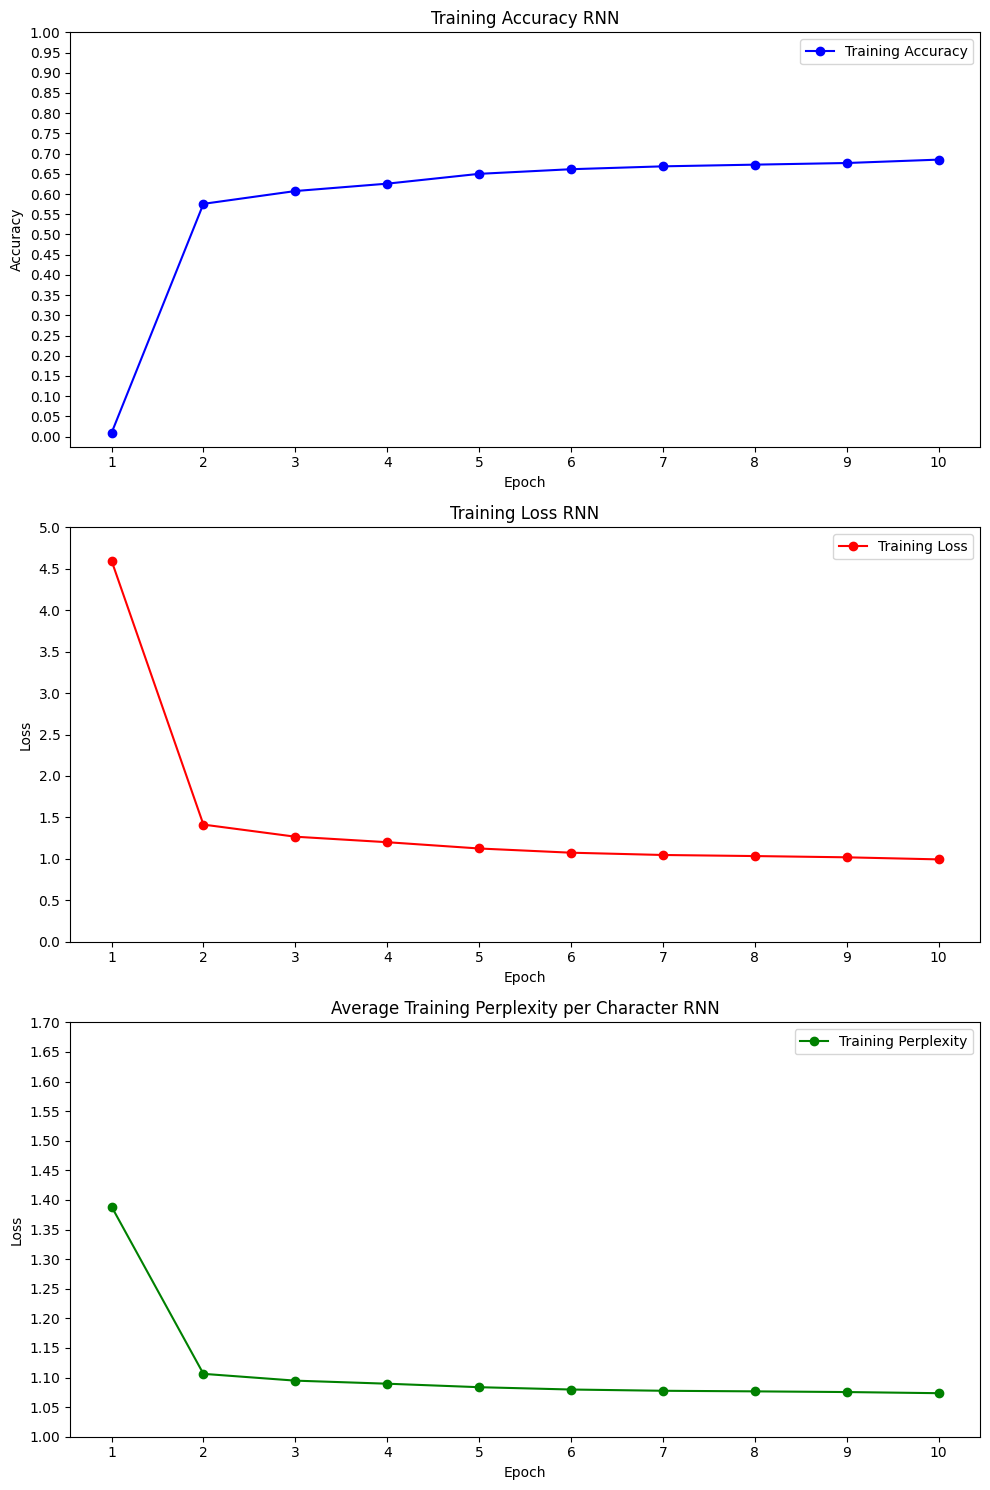

In [9]:
# RNN_model Training
tr_acc, tr_loss, tr_perplexities = RNN_model.train()

plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1)
plt.title("Training Accuracy RNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1, RNN_model.max_epoch + 1, 1), tr_acc, 'o-', color="b", label="Training Accuracy")
plt.legend(loc="best")
plt.xticks(range(1, RNN_model.max_epoch + 1))
plt.yticks([i * 0.05 for i in range(0, 21)])

# Plot for Training Loss
plt.subplot(3, 1, 2)
plt.title("Training Loss RNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, RNN_model.max_epoch + 1, 1), tr_loss, 'o-', color="r", label="Training Loss")
plt.legend(loc="best")
plt.xticks(range(1, RNN_model.max_epoch + 1))
plt.yticks([i * 0.5 for i in range(0, 11)])

# Plot for Training Perplexity
plt.subplot(3, 1, 3)
plt.title("Average Training Perplexity per Character RNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, RNN_model.max_epoch + 1, 1), tr_perplexities, 'o-', color="g", label="Training Perplexity")
plt.legend(loc="best")
plt.xticks(range(1, RNN_model.max_epoch + 1))
plt.yticks([i * 0.05 for i in range(20, 35)])

plt.tight_layout()
plt.show()

In [10]:
# RNN_model Testing
test_prompt = 'rick: mmm panda express'
print(RNN_model.test(test_prompt, 1000))

--start testing...
['r', 'i', 'c', 'k', ':', ' ', 'm', 'm', 'm', ' ', 'p', 'a', 'n', 'd', 'a', ' ', 'e', 'x', 'p', 'r', 'e', 's', 's']
rick: mmm panda express?  ,.. ??. u .u.   uu!i?u  . u  ?   i?,u  ?.??   .  u?u    ! ?  ?) ? i   u., ?.??    u   ???.e,   ,.?u u ?u ?  ?u?  ..u    )   u.?u  .     .?  ?? . .?.    ?   u.?   .    .u   .. ?u ?u  .?ui  ?.uu ? ?uu.u  ? u?   u.   .?  ? i,u ? ?  . ?  ?.u ? u,.   u        u     ,  ,  f? .  .  ,  i.? ..u?.u?.? u??u  ?.     ?  !  f?.     i ? ??. ? .  u ?u.e ? ? ? ..  u. ?   .. u   ???.    ?  u.,  .u    u  u?e?    .?  .  i .u?u  ,, a.  ?.?    ,..u.?f  .?   ? ?..   ,?   u   u??uuu?? u ?    ?, ?.buu ? ??     u   ?  ? ?u   . ???? u    i! ui??.?    e? . uu? i?.u ?     ?u e  .? ?uue ?u, ue u?    u.a? e        u,       ee  ??u  ?. :? ,?,u.?? ! f? .u  ee.?.ue?a?i ?  u  ??.!.  e u .i??? ?,u  u , u: . ?  u )   ?   ?  i .u? e? ? .u??.euu  u ?u?u?u   u.? ,. .??? ?     ?     u u u.u m?  .    ? i?   ? :u  ?u?! ? ? ?,   u .f.  u  u     .      u? ?u?u? u u? .  ,u

In [34]:
# Hyperparameter Tuning for RNN with LSTM
# Learning Rates = [1e-1, 1e-2, 1e-3, 1e-4]
# size = [32, 64, 128, 256, 512]
# num_layers = [2, 3, 4]
# batch_size = [32, 64, 128, 256, 512]
# word_window = [2, 4, 6, 8, 10, 12, 14, 16]

hyperparameters = {
    'learning_rate': [1e-3, 1e-4],
    'size': [512, 1024],
    'num_layers': [2],
    'batch_size': [128, 256, 512],
    'word_window': [12, 14],
    'dropout': [0.1, 0.15]
}

# Best: (0.001, 512, 2, 256, 14, 0.1), (0.001, 1024, 2, 128, 14, 0.1)
best_hyperparameters = RNN_with_LSTM_model.grid_search(hyperparameters)

print(best_hyperparameters)

(0.001, 512, 2, 128, 12, 0.1)
--start training...
[0, 0] loss: 4.593136310577393 accuracy: 0.005859375 perplexity: 1.466328062631555


KeyboardInterrupt: 

--start training...
[0, 0] loss: 4.593474388122559 accuracy: 0.016741071428571428 perplexity: 1.3883351749401585
[1, 0] loss: 1.2224695682525635 accuracy: 0.6199776785714286 perplexity: 1.091245009401615
[2, 0] loss: 0.9810951948165894 accuracy: 0.6830357142857143 perplexity: 1.0725920849217658
[3, 0] loss: 0.9310566186904907 accuracy: 0.7042410714285714 perplexity: 1.0687652863586445
[4, 0] loss: 0.8786554336547852 accuracy: 0.7265625 perplexity: 1.0647724372688638
[5, 0] loss: 0.8328059911727905 accuracy: 0.7410714285714286 perplexity: 1.0612910537467273
[6, 0] loss: 0.8208349943161011 accuracy: 0.7393973214285714 perplexity: 1.0603839621967532
[7, 0] loss: 0.8432428240776062 accuracy: 0.7282366071428571 perplexity: 1.0620825285412447
[8, 0] loss: 0.8224056959152222 accuracy: 0.7494419642857143 perplexity: 1.0605029364981762
[9, 0] loss: 0.7890158295631409 accuracy: 0.7444196428571429 perplexity: 1.0579766608875856


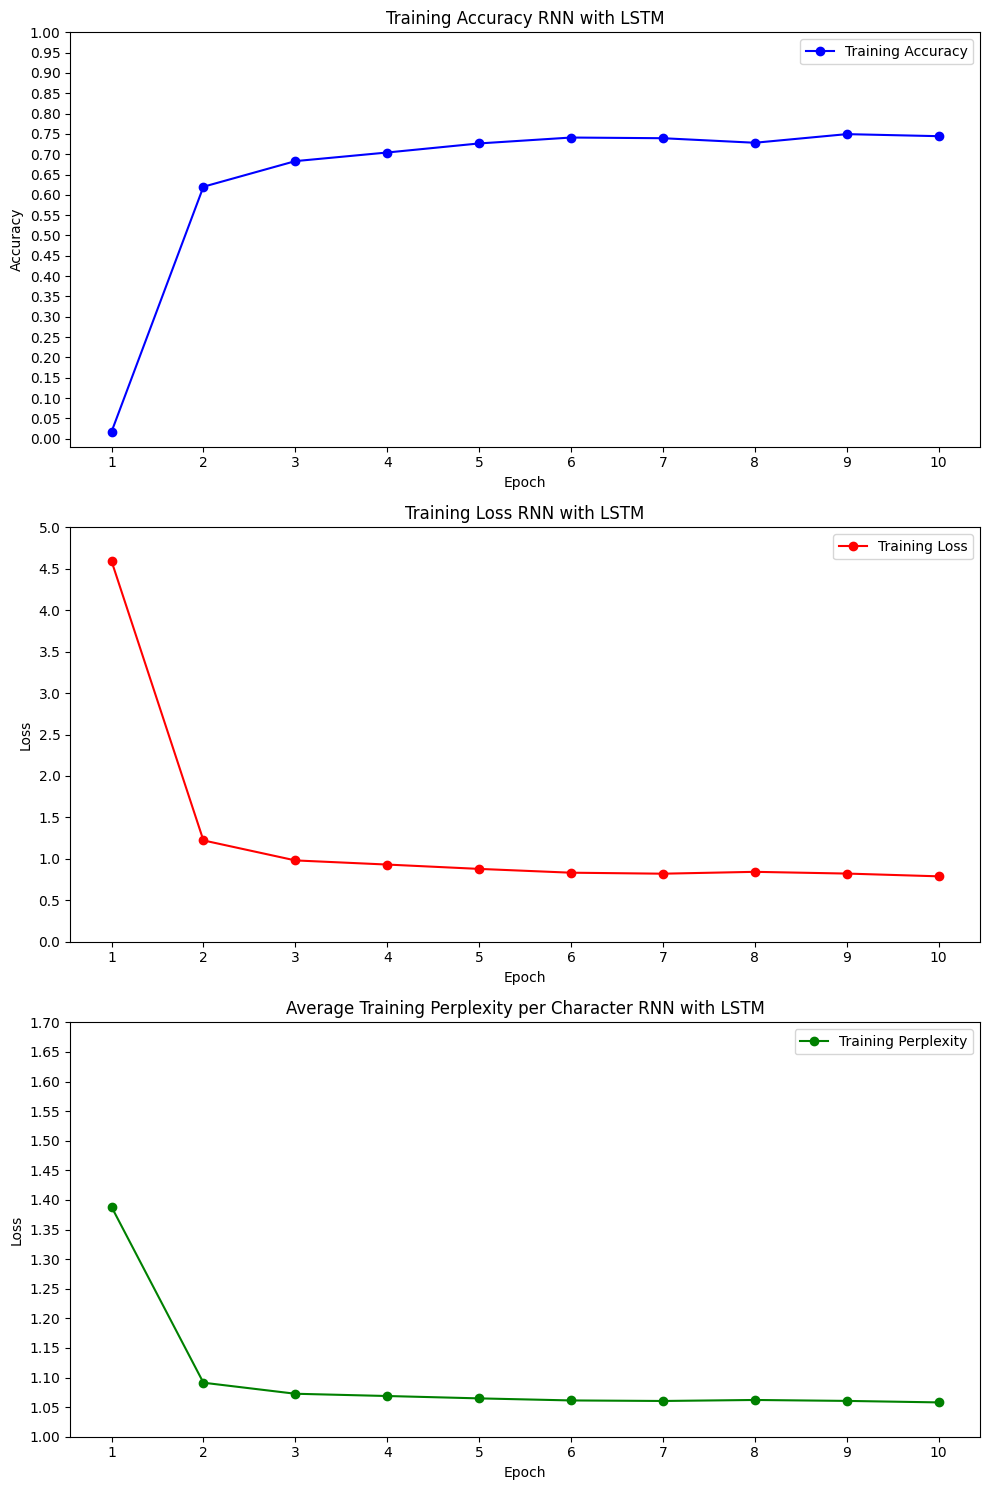

In [11]:
# RNN_with_LSTM_model Training
tr_acc, tr_loss, tr_perplexities = RNN_with_LSTM_model.train()

plt.figure(figsize=(10, 15))
plt.subplot(3, 1, 1)
plt.title("Training Accuracy RNN with LSTM")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1, RNN_with_LSTM_model.max_epoch + 1, 1), tr_acc, 'o-', color="b", label="Training Accuracy")
plt.legend(loc="best")
plt.xticks(range(1, RNN_with_LSTM_model.max_epoch + 1))
plt.yticks([i * 0.05 for i in range(0, 21)])

# Plot for Training Loss
plt.subplot(3, 1, 2)
plt.title("Training Loss RNN with LSTM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, RNN_with_LSTM_model.max_epoch + 1, 1), tr_loss, 'o-', color="r", label="Training Loss")
plt.legend(loc="best")
plt.xticks(range(1, RNN_with_LSTM_model.max_epoch + 1))
plt.yticks([i * 0.5 for i in range(0, 11)])

# Plot for Training Perplexity
plt.subplot(3, 1, 3)
plt.title("Average Training Perplexity per Character RNN with LSTM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, RNN_with_LSTM_model.max_epoch + 1, 1), tr_perplexities, 'o-', color="g", label="Training Perplexity")
plt.legend(loc="best")
plt.xticks(range(1, RNN_with_LSTM_model.max_epoch + 1))
plt.yticks([i * 0.05 for i in range(20, 35)])

plt.tight_layout()
plt.show()

In [12]:
# RNN_with_LSTM_model Testing
test_prompt = 'Rick: erm, what the sigma?\n\n\nMorty: '
print(RNN_with_LSTM_model.test(test_prompt, 5000))

--start testing...
Rick: erm, what the sigma?


Morty: He means nothing more with real?


Jerry: Psst, Beth. He pussy on a math time. I mean, you know, we have any wafer cookies? (grabs ice from Morty) Morty? That here's some kind of a bunch of wheat you! *points his cane at Alexander's hand. The shoes have control me on David Letterman?


Rick 2: I'm really sorry about all for milk?" I'm like that, so when they come and I mentally made the monsters, Beth.


Beth: Require humans! Jerry!


Jerry: Guys sating! (set on fire) And also when away) Mm! (stops at Jerry and Jacob came into the kitchen with his forearm and state as Beth as she started beeping and starts laugh is forcifician it, davin? Oh, man, it looks cool, huh?


The only monster case and gives Summer the horing an energy destructive, but you can't see anything badly.)


Summers 2, 6, 9, 12, 13, 15, 17, 28: Get him barlacking out Fido with a baby)


Gracine Na! (he and Morty and their adventure's good... I get those move for m

In [8]:
# This is just in case the GPU runs out of memory. Usually only needed for Grid-Search
import gc

gc.collect()

torch.cuda.empty_cache()